## Importing 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from transformers import TFRobertaModel
from transformers import AutoTokenizer


import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = "datasets/uznews_preprocessed.csv"
df = pd.read_csv(filename)
df.head()

,text,clean_text,sentiment
0,O'zbekiston futbol assotsiatsiyasi intizom qo'...,ozbekiston futbol assotsiatsiyasi intizom qomi...,1
1,Rustam Yusupov Toshkent obodonlashtirish Bosh ...,rustam yusupov toshkent obodonlashtirish bosh ...,1
2,Xitoyning Yutong kompaniyasi yil oxirigacha Sa...,xitoyning yutong kompaniyasi yil oxirigacha sa...,1
3,Samarqand viloyatida 3 gektar o'rmon xo'jaligi...,samarqand viloyatida gektar ormon xojaligi yer...,1
4,Andijon viloyati Xonobodda bir kishi davlat or...,andijon viloyati xonobodda bir kishi davlat or...,0


## Class Balancing by RandomOverSampler

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['clean_text']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['clean_text', 'sentiment']);

In [ ]:
train_os['sentiment'].value_counts()

## Train - Validation - Test split

In [ ]:
X = train_os['clean_text'].values
y = train_os['sentiment'].values

In [ ]:
seed=42

# split the original data into train and TEST sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

# split the remaining 90% of the data into train and VALIDATION sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=seed)

## One hot encoding

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

# UzRoberta

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('rifkat/uztext-3Gb-BPE-Roberta')

In [ ]:
MAX_LEN=512

In [ ]:
# tokenize the training data
train_inputs = tokenizer(X_train.tolist(), max_length=MAX_LEN, padding='max_length', truncation=True)
train_input_ids = np.array(train_inputs['input_ids'])
train_attention_masks = np.array(train_inputs['attention_mask'])

# tokenize the validation data
val_inputs = tokenizer(X_valid.tolist(), max_length=MAX_LEN, padding='max_length', truncation=True)
val_input_ids = np.array(val_inputs['input_ids'])
val_attention_masks = np.array(val_inputs['attention_mask'])

# tokenize the test data
test_inputs = tokenizer(X_test.tolist(), max_length=MAX_LEN, padding='max_length', truncation=True)
test_input_ids = np.array(test_inputs['input_ids'])
test_attention_masks = np.array(test_inputs['attention_mask'])

# Modeling

In [ ]:
def create_model(roberta_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(
        learning_rate=1e-5, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=1e-7
    )
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = roberta_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('rifkat/uztext-3Gb-BPE-Roberta', from_pt=True)

In [ ]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

In [ ]:
model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

# Results

In [ ]:
result = model.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred =  np.zeros_like(result)
y_pred[np.arange(len(y_pred)), result.argmax(1)] = 1

In [ ]:
print('\tClassification Report:\n\n',classification_report(y_test,y_pred, target_names=['Negative', 'Positive']))

In [ ]:
# # save the model
# model.save('news_sentiment_uzbek_model.h5')

## Visualization

In [6]:
news_df = pd.read_csv('datasets/news_dataset_labeled_simplified.csv')
news_df['sentiment'] = news_df['sentiment'].replace({'positive': 1, 'negative': 0}, regex=True)
news_df['sentiment'].value_counts()

1    3219
0    1485
Name: sentiment, dtype: int64

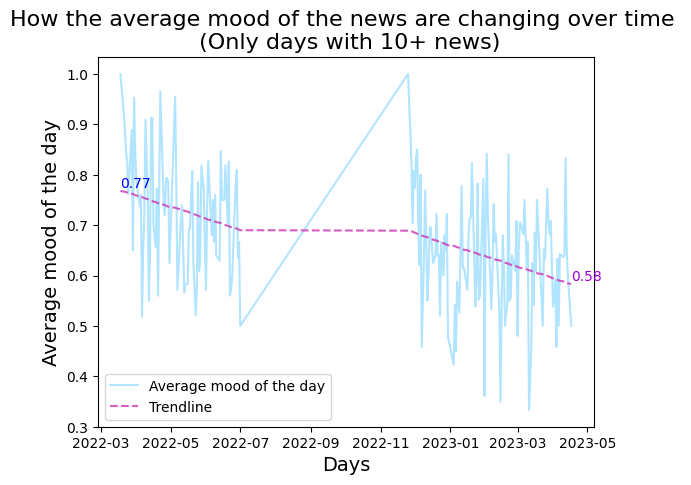

In [7]:
%matplotlib inline

# filter for dataframe
filter_number = 10
news_df['date'] = pd.to_datetime(news_df['date'])
grouped_df = news_df.groupby(news_df['date'].dt.date).filter(lambda x: len(x['sentiment']) >= filter_number)
daily_avg = grouped_df.groupby(grouped_df['date'].dt.date)['sentiment'].mean()

# trendline
z = np.polyfit(range(len(daily_avg.index)), daily_avg.values, 1)
trendline = np.poly1d(z)
trendline_start = trendline(0)
trendline_end = trendline(len(daily_avg.index) - 1)

# trendline plot
fig, ax = plt.subplots()
ax.plot(daily_avg.index, daily_avg.values, label="Average mood of the day", color='#7ed2ff', alpha=0.6)

# anotations
ax.plot(daily_avg.index, trendline(range(len(daily_avg.index))), linestyle="--", label="Trendline", color='#cd34b5', alpha=0.8)
ax.text(daily_avg.index[0], trendline_start, f'{trendline_start:.2f}', ha='left', va='bottom', color='#0000ff')
ax.text(daily_avg.index[-1], trendline_end, f'{trendline_end:.2f}', ha='left', va='bottom', color='#9d02d7')

# labels
ax.set_xlabel("Days", fontsize=14)
ax.set_ylabel("Average mood of the day", fontsize=14)
# ax.set_ylim(ymin=0) 
ax.set_title("How the average mood of the news are changing over time \n (Only days with 10+ news)", fontsize=16)
ax.legend()
plt.show()

## Test with user input